# EGL Train Epoch Tests


## Imports

In [4]:
%load_ext autoreload
%autoreload 2

import os
import torch
import random

import torch.nn as nn
import numpy as np
import diveslowlearnfast as dlf
import matplotlib.pyplot as plt
import torch.nn.functional as F

from diveslowlearnfast.config import Config
from diveslowlearnfast.datasets import Diving48Dataset
from diveslowlearnfast.train import helper as train_helper
from diveslowlearnfast import load_checkpoint
from diveslowlearnfast.train.helper import get_train_transform, get_test_transform, get_mask_transform, get_base_transform
from diveslowlearnfast.models import SlowFast
from diveslowlearnfast.egl import ExplainerStrategy
from diveslowlearnfast.egl.run_train_epoch import get_loss_params, get_mask_indices
from diveslowlearnfast.loss.rrr import RRRLoss
from diveslowlearnfast.loss.dice import DiceLoss


cfg = Config()
cfg.DATA.DATASET_PATH = '/Users/youritomassen/Projects/xai/data/Diving48/'
cfg.TRAIN.BATCH_SIZE = 2
cfg.DATA.TEST_CROP_SIZE = 224

device = torch.device('cpu')
model = SlowFast(cfg)
_, optimiser, *_ = train_helper.get_train_objects(cfg, model)
model, *_ = load_checkpoint(model, '../misc/checkpoint.pth', optimiser, device)

explainer = ExplainerStrategy.get_explainer(model, cfg, device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



## Masks Cache
Evaluate the masks cache functionality.

1. First construct a dataloader with the right parameters.
2. Then forward the data through the model.
3. Lastly apply the loss function to the params.

In [5]:
vidnames = ['3PLiUG_DuC8_00208', '5i1begTTucc_00043', 'cYkUl8MrXgA_00252']
dataset = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    cfg.SLOWFAST.ALPHA,
    transform_fn=get_test_transform(cfg),
    video_ids=vidnames,
    loader_mode='mp4',
    mask_type='cache',
    masks_cache_dir='.masks'
)

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=cfg.TRAIN.BATCH_SIZE,
    shuffle=False,
    num_workers=2
)
loader_iter = iter(loader)

In [6]:
x, y, _, _, _, masks = dataset[0]
assert masks is not None
assert len(masks) == 2

In [7]:
xb, yb, _, masks = dlf.get_batch(loader_iter, device)
masks[0].shape, masks[1].shape

(torch.Size([2, 1, 4, 224, 224]), torch.Size([2, 1, 32, 224, 224]))

In [8]:
cfg.EGL.METHOD = 'cache'
cfg.EGL.LOSS_FUNC = 'rrr_v2'
cfg.GRADCAM.TARGET_LAYERS = ['s5/pathway0_res2', 's5/pathway1_res2']
loss_fn = RRRLoss()
exp = ExplainerStrategy.get_explainer(model, cfg, device)
inputs = dlf.to_slowfast_inputs(xb, cfg.SLOWFAST.ALPHA, requires_grad=True)
maps, logits = exp(inputs)
loss_params = get_loss_params(cfg, maps, inputs, yb, logits, masks=masks)

loss, losses = loss_fn(**loss_params)
loss, losses, F.cross_entropy(logits, yb)

(tensor(13345.9863, grad_fn=<AddBackward0>),
 {'ce_loss': 1.953347086906433,
  'gradient_loss_path_0': 7500.419921875,
  'gradient_loss_path_1': 5843.61376953125,
  'total_loss': 13345.986328125},
 tensor(1.9533, grad_fn=<NllLossBackward0>))

## GradCAM Masks

In [9]:
dataset = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    cfg.SLOWFAST.ALPHA,
    transform_fn=get_test_transform(cfg),
    video_ids=vidnames,
    loader_mode='mp4',
)

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)


loader_iter = iter(loader)

x, y, _, _, _, masks = dataset[0]
assert masks is not None
assert masks == False

In [10]:
xb, yb, video_ids, *_ = dlf.get_batch(loader_iter, device)

In [11]:
cfg.EGL.METHOD = 'gradcam'
cfg.EGL.LOSS_FUNC = 'rrr_v2'
cfg.GRADCAM.TARGET_LAYERS = ['s5/pathway0_res2', 's5/pathway1_res2']

loss_fn = RRRLoss([0.01, 0.01])
inputs = dlf.to_slowfast_inputs(xb, cfg.SLOWFAST.ALPHA, requires_grad=True)
exp = ExplainerStrategy.get_explainer(model, cfg, device)
maps, logits = exp(inputs)
loss_params = get_loss_params(cfg, maps, inputs, yb, logits,
                              hard_video_ids={'5i1begTTucc_00043'},
                              video_ids=video_ids)
loss, losses = loss_fn(**loss_params)
loss, losses, F.cross_entropy(logits, yb)

[ True False False]


(tensor(0.6369, grad_fn=<AddBackward0>),
 {'ce_loss': 0.5342092514038086,
  'gradient_loss_path_0': 0.10012008994817734,
  'gradient_loss_path_1': 0.0025249281898140907,
  'total_loss': 0.6368542313575745},
 tensor(0.5342, grad_fn=<NllLossBackward0>))

## Segment Masks

In [12]:
vidnames = ['3qq031609lA_00002', 'iv0Gu1VXAgc_00167', 'aektxm8cLdo_00000']

dataset = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    cfg.SLOWFAST.ALPHA,
    transform_fn=get_test_transform(cfg),
    mask_transform_fn=get_mask_transform(cfg),
    video_ids=vidnames,
    loader_mode='jpg',
    mask_type='segments'
)

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=cfg.TRAIN.BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

x, y, _, _, _, masks = dataset[0]
assert masks is not None
masks.shape

torch.Size([1, 32, 224, 224])

In [13]:
xb, yb, _, masks = dlf.get_batch(iter(loader), device)

In [14]:
cfg.EGL.METHOD = 'ogl'
cfg.EGL.LOSS_FUNC = 'dice'
cfg.GRADCAM.TARGET_LAYERS = ['s5/pathway0_res2', 's5/pathway1_res2']
cfg.EGL.WORST_PERFORMER_STRATEGY = 'all'
loss_fn = DiceLoss(nn.CrossEntropyLoss())
inputs = dlf.to_slowfast_inputs(xb, cfg.SLOWFAST.ALPHA, requires_grad=True)
exp = ExplainerStrategy.get_explainer(model, cfg, device)
maps, logits = exp(inputs)
loss_params = get_loss_params(cfg, maps, inputs, yb, logits, masks=masks)
loss, losses = loss_fn(**loss_params)
loss, losses

[ True  True]


(tensor(2.8309, grad_fn=<AddBackward0>),
 {'ce_loss': tensor(1.9014, grad_fn=<MulBackward0>),
  'dice_loss': tensor(0.9295),
  'total_loss': tensor(2.8309, grad_fn=<AddBackward0>)})

## Classify Mask
For all wrong classifications we generate a mask

In [2]:
vidnames = ['3qq031609lA_00002', 'iv0Gu1VXAgc_00167', 'aektxm8cLdo_00000']

dataset = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    cfg.SLOWFAST.ALPHA,
    transform_fn=get_test_transform(cfg),
    mask_transform_fn=get_mask_transform(cfg),
    video_ids=vidnames,
    loader_mode='mp4'
)

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

loader_iter = iter(loader)

x, y, _, _, _, masks = dataset[0]
assert masks is not None

In [3]:
xb, yb, *_ = next(loader_iter)

In [ ]:
cfg.EGL.METHOD = 'gradcam'
cfg.EGL.LOSS_FUNC = 'rrr_v2'
cfg.GRADCAM.TARGET_LAYERS = ['s5/pathway0_res2', 's5/pathway1_res2']
cfg.EGL.WORST_PERFORMER_STRATEGY = 'classify'
loss_fn = RRRLoss(lambdas=[0.01, 0.01])
inputs = dlf.to_slowfast_inputs(xb, cfg.SLOWFAST.ALPHA, requires_grad=True)
exp = ExplainerStrategy.get_explainer(model, cfg, device)
maps, logits = exp(inputs)
loss_params = get_loss_params(cfg, maps, inputs, yb, logits)
loss, losses = loss_fn(**loss_params)
loss, losses

## Test `train_helper`
Evaluate the functionality of `train_helper` for fetching the correct criterion and dataloader which - in addition to x, y samples - also fetches
segmentation masks.

In [18]:
from diveslowlearnfast.train import helper as train_helper

cfg = Config()
cfg.DATA.DATASET_PATH = '/Users/youritomassen/Projects/xai/data/Diving48/'
cfg.EGL.ENABLED = True
cfg.EGL.METHOD = 'ogl'
cfg.EGL.LOSS_FUNC = 'dice'
cfg.GRADCAM.TARGET_LAYERS = ['s5/pathway0_res2', 's5/pathway1_res2']

loader, dataset = train_helper.get_train_loader_and_dataset(
    cfg,
    video_ids=['3qq031609lA_00002', 'iv0Gu1VXAgc_00167', 'aektxm8cLdo_00000'] # these video_ids contain segments
)
loader_iter = iter(loader)
x, y, _, _, _, m = dataset[1]
x.shape, m.shape

(torch.Size([3, 32, 224, 224]), torch.Size([1, 32, 224, 224]))

In [7]:
xb, yb, _, _, _, masks = next(loader_iter)

In [8]:
xb.shape, yb.shape, mask.shape

(torch.Size([3, 3, 32, 224, 224]),
 torch.Size([3]),
 torch.Size([3, 1, 32, 224, 224]))

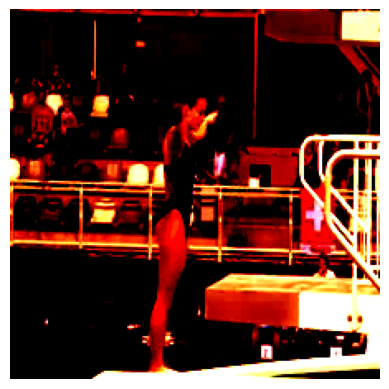

In [19]:
dlf.frameshow(x.permute(1, 2, 3, 0))

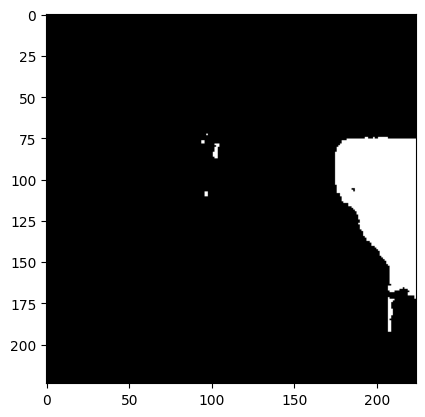

In [20]:
plt.imshow(m[0][0], cmap='gray')